# Using Variational Autoencoder and Deep Feature Loss to Generate Faces

From the "Using Variational Autoencoder to Generate Faces" example, we see that using VAE, we can generate realistic human faces, but the generated image is a little blury. Though, you can continue to tuning the hyper paramters or using more data to get a better result, in this example, we adopted the approach in [this paper](https://arxiv.org/abs/1610.00291). That is, instead of using pixel-by-pixel loss of between the original images and the generated images, we use the feature map generated by a pre-trained CNN network to define a feature perceptual loss. As you will see, the generated images will become more vivid.

Adjust DATA_PATH to your own data path, and VGG_PATH to your model path.
You can download the model from [https://github.com/intel-analytics/analytics-zoo/blob/master/docs/docs/ProgrammingGuide/image-classification.md#download-link](https://github.com/intel-analytics/analytics-zoo/blob/master/docs/docs/ProgrammingGuide/image-classification.md#download-link)

In [1]:
import numpy as np
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import Model,Sequential
from zoo.pipeline.api.keras.utils import *
from utils import *
from glob import glob
from zoo.pipeline.api.net import Net


# Adjust to your own data_path
DATA_PATH = os.getenv("ANALYTICS_ZOO_HOME") + "/apps/variational-autoencoder/img_align_celeba"
# Adjust to your own model_path
VGG_PATH = os.getenv("ANALYTICS_ZOO_HOME") + "/apps/variational-autoencoder/analytics-zoo_vgg-16_imagenet_0.1.0.model"

IMAGE_SIZE = 148
IMAGE_ROW = 64
IMAGE_COL = 64
Z_DIM = 100
ENCODER_FILTER_NUM = 32
IMAGE_CHANNELS = 3

init_engine()

## Define the Model

We are using the same model as "Using Variational Autoencoder to Generate Faces" example.

In [2]:
def conv_bn_lrelu(out_channles, in_channels, in_row, in_col,kw=4, kh=4, sw=2, sh=2):
    input0 = Input(shape=(in_channels, in_row, in_col))
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(input0)
    batch = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch)
    model = Model([input0], [relu])
    return model

def upsample_conv_bn_lrelu(out_channles, in_channels, in_row, in_col, out_width, out_height, kw=3, kh=3, sw=1, sh=1):
    input0 = Input(shape=(in_channels, in_col, in_row))
    resize = ResizeBilinear(out_width, out_height)(input0)
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(resize)
    batch1 = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch1)
    model = Model([input0], [relu])
    return model

In [3]:
def get_encoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    
    #conv
    conv1 = conv_bn_lrelu(ENCODER_FILTER_NUM, IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL)(input0)  # 32 * 32 * 32
    conv2 = conv_bn_lrelu(ENCODER_FILTER_NUM * 2, ENCODER_FILTER_NUM, 32, 32)(conv1)  # 16 * 16 * 64
    conv3 = conv_bn_lrelu(ENCODER_FILTER_NUM * 4, ENCODER_FILTER_NUM * 2, 16, 16)(conv2)  # 8 * 8 * 128
    conv4 = conv_bn_lrelu(ENCODER_FILTER_NUM * 8, ENCODER_FILTER_NUM * 4, 8, 8)(conv3)  # 4 * 4 * 256
    flatten = Flatten()(conv4)
    inter = Dense(2048)(flatten)
    inter = Reshape((1, 1, 2048))(inter)
    inter = BatchNormalization()(inter)
    inter = Activation('relu')(inter)
    inter = Flatten()(inter)
    
    # fully connected to generate mean and log-variance
    mean = Dense(Z_DIM)(inter)
    log_variance = Dense(Z_DIM)(inter)

    model = Model([input0], [mean, log_variance])
    return model


In [4]:
def get_decoder_cnn():
    input0 = Input(shape=(Z_DIM,))
    linear = Dense(2048)(input0)
    linear = Dense(4 * 4 * ENCODER_FILTER_NUM * 8)(linear)
    reshape = Reshape((ENCODER_FILTER_NUM * 8, 4, 4))(linear)
    bn = BatchNormalization(ENCODER_FILTER_NUM * 8)(reshape)

    # upsampling
    up1 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 4, ENCODER_FILTER_NUM * 8, 4, 4, 8, 8)(bn)  # 8 * 8 * 128
    up2 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 2, ENCODER_FILTER_NUM * 4, 8, 8, 16, 16)(up1)  # 16 * 16 * 64
    up3 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM, ENCODER_FILTER_NUM * 2, 16, 16, 32, 32)(up2)  # 32 * 32 * 32
    up4 = upsample_conv_bn_lrelu(IMAGE_CHANNELS, ENCODER_FILTER_NUM, 32,32, 64, 64)(up3)  # 64 * 64 * 3
    output = Activation('sigmoid')(up4)

    model = Model([input0], [output])
    return model

In [5]:
def get_autoencoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)

    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

## Load the pre-trained CNN model

In [6]:
def get_vgg():
    vgg_whole = Net.load_bigdl(VGG_PATH)
    vgg_light = vgg_whole.new_graph(["relu1_2"])
    vgg_light.freeze()
    return vgg_light

In [7]:
vgg = get_vgg()
print("Get VGG Model")

Get VGG Model


In [8]:
autoencoder, decoder_model = get_autoencoder_cnn()

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasBatchNormalization
creating: createZooKerasActivation
creating: createZooKerasFlatten
creating: createZooKerasDense
creati

## Load the Datasets

In [9]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))

    rdd_train_images = sc.parallelize(data_files[:100000]) \
        .map(lambda path: inverse_transform(get_image(path, IMAGE_SIZE)).transpose(2, 0, 1))
    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [10]:
from pyspark import SparkContext
sc =SparkContext.getOrCreate()

train_data = get_data()

## Define the Training Objective

In [11]:
batch_size = 64
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 0.005) # You may want to twick this parameter
criterion.add(TransformerCriterion(MSECriterion(), vgg, vgg), 1.0)



creating: createParallelCriterion
creating: createKLDCriterion
creating: createMSECriterion
creating: createTransformerCriterion


## Compile the Model

In [12]:
autoencoder.compile(optimizer=Adam(0.001), loss=criterion)
import os
import datetime as dt
if not os.path.exists("./log"):
    os.makedirs("./log")
                
app_name='vae-faces-deep-loss'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
autoencoder.set_tensorboard(log_dir='./log/',app_name=app_name)

print("Saving logs to ", app_name)

creating: createAdam
('Saving logs to ', 'vae-faces-deep-loss20180607-190859')


## Spin Up the Training

This could take a while. It took about 6 hours on a desktop with a intel i7-6700 cpu and 40GB java heap memory. You can reduce the training time by using less data (some changes in the "Load the Dataset" section), but the performce may not as good.

In [13]:
autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 6)

In [14]:
def gen_image_row():
    return np.column_stack([decoder_model.forward(np.random.randn(1, Z_DIM)).reshape(3, 64, 64).transpose(1, 2, 0) for s in range(8)])

def gen_image():
    return np.row_stack([gen_image_row() for i in range(8)])


In [15]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

from matplotlib.pyplot import imshow

Populating the interactive namespace from numpy and matplotlib


/home/wangzhiqi/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


creating: createTrainSummary


Text(0.5,1,'loss')

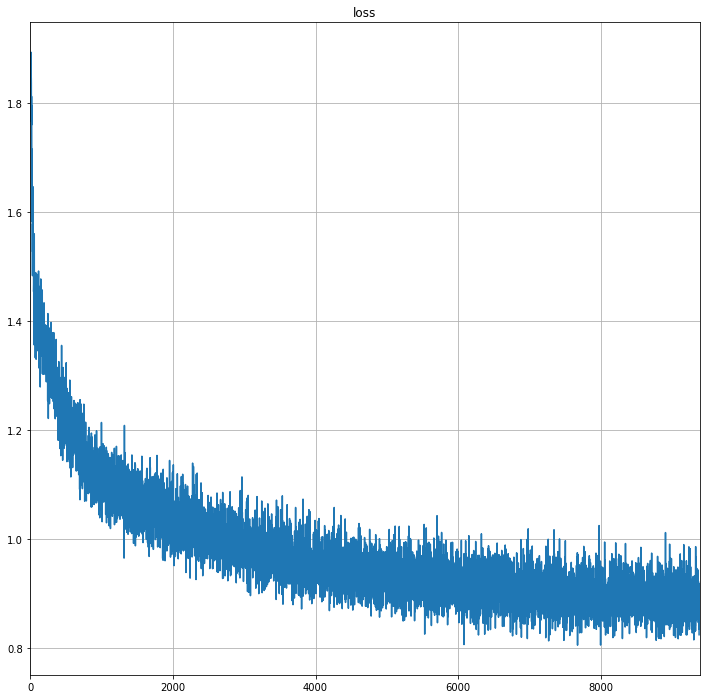

In [16]:
train_summary = TrainSummary('./log/', app_name)
loss = np.array(train_summary.read_scalar("Loss"))
plt.figure(figsize = (12,12))
plt.plot(loss[:,0], loss[:,1], label='loss')
plt.xlim(0, loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

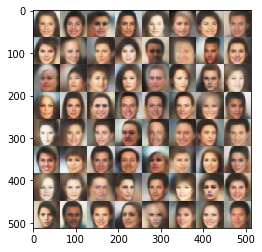

In [17]:
img = gen_image()
imshow(img)